In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import re

import numpy as np
import pandas as pd
from tqdm import tqdm
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from joblib import Parallel, delayed

from utils import calc_metrics

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
X = pd.read_csv('data/x.csv', index_col='date')
y = pd.read_csv('data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

### Мешок слов плюс линейная модель

Создадим функцию для тестирования наших моделей. Зададим начальный порог и будем обучать, модель на наблюдениях до порога, а тестировать на одном наблюдении после. Двигая порог протестируем нашу модель. И потом сравним с истинными ответами. Качество всех наших моделей будем записывать в табличку.

Обучим логистическую регрессию с l1 регуляризацией, она нам покажет какие слова не влияют на предсказание модели.

In [3]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = CountVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

bow = vectorizer.transform(X.release)

In [4]:
auc = Parallel(n_jobs=-1)(delayed(
    lambda c: calc_metrics(bow, y, LogisticRegression, name='bow l1 only release', plot=False, solver='liblinear', penalty='l1', C=c.item())
)(c) for c in np.linspace(0.001, 10, 30))

roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=8.965620689655173, penalty='l1', solver='liblinear')
ROC-AUC = 0.7688200434195857


Рассмотрим подробнее лучшую модель.

              precision    recall  f1-score   support

        -1.0       0.70      0.70      0.70        23
         0.0       0.54      0.58      0.56        26
         1.0       0.71      0.63      0.67        19

    accuracy                           0.63        68
   macro avg       0.65      0.63      0.64        68
weighted avg       0.64      0.63      0.63        68



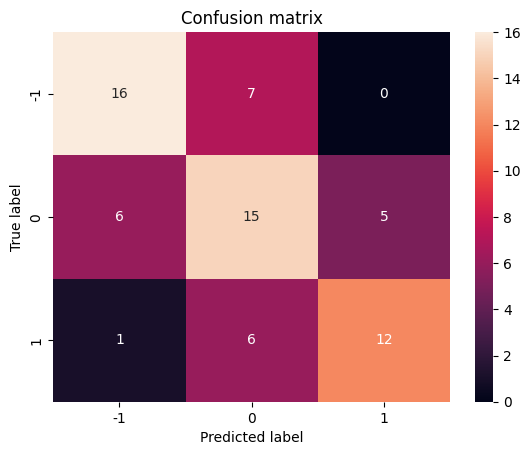

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178


In [5]:
metric, model = calc_metrics(bow, y, LogisticRegression, name='bow l1 only release', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Мы немного улучшили минимальный бейзлайн, подберем гиперпараметры для elasticnet, и только на тех словах, веса при которых не занулила прошлая модель. Мы таким образом заглянем в тестовую выборку, но скорее всего это будет не критично. Таким образом расширим множество стоп слов, словами которые не важны для прошлой модели.

In [6]:
STOP_WORDS |= set(vectorizer.get_feature_names_out()[np.all(model.coef_ == 0, axis=0)])

In [7]:
vectorizer = CountVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

bow = vectorizer.transform(X.release)

In [8]:
auc = Parallel(n_jobs=-1)(delayed(
    lambda c, l1_ratio: calc_metrics(
        bow, y, 
        LogisticRegression,
        name='bow l2', 
        plot=False, 
        solver='saga', 
        penalty='elasticnet', 
        C=c, 
        max_iter=10000, 
        l1_ratio=l1_ratio
    )
)(c, l1_ratio) for c in np.linspace(0.1, 30, 10) for l1_ratio in np.logspace(-3, 0, 6))
    
roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=3.422222222222222, l1_ratio=0.001, max_iter=10000,
                   penalty='elasticnet', solver='saga')
ROC-AUC = 0.8405650413659567


Обучим лучшую модель и посмотрим ее оценки качества подробнее.

              precision    recall  f1-score   support

        -1.0       0.77      0.74      0.76        23
         0.0       0.57      0.65      0.61        26
         1.0       0.75      0.63      0.69        19

    accuracy                           0.68        68
   macro avg       0.70      0.67      0.68        68
weighted avg       0.69      0.68      0.68        68



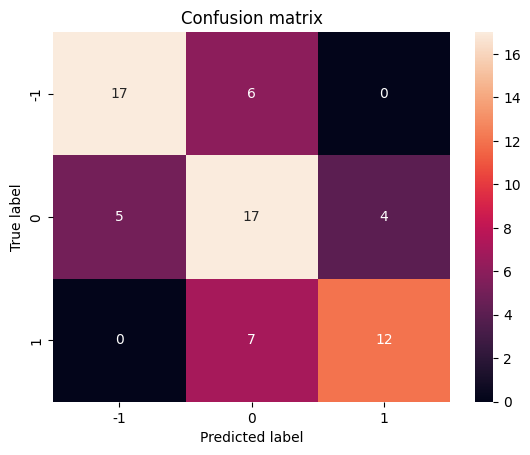

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178
bow elasticnet,0.676471,0.682804,0.696465,0.674852,0.837479,0.840521


In [9]:
metric, _ = calc_metrics(bow, y, LogisticRegression, name='bow elasticnet', **best_model.get_params())
metrics = pd.concat((metrics, metric))
metrics

Качество немного подросло. Попробуем обучить мешок слов не только на пресс-релизах, но и на названиях.

In [10]:
vectorizer_title = CountVectorizer(
    preprocessor=preprocessor,
)

vectorizer_title.fit(X.title)

bow_title = vectorizer_title.transform(X.title)

In [11]:
bow_title_release = np.concatenate((bow.toarray(), bow_title.toarray()), axis=1)

Подберем гиперпараметры для модели обучаемой на названии релиза и самом релизе.

In [12]:
auc = Parallel(n_jobs=-1)(delayed(
    lambda c, l1_ratio: calc_metrics(
        bow_title_release, y,
        LogisticRegression, 
        name='bow', 
        plot=False, 
        solver='saga', 
        penalty='elasticnet', 
        C=c, 
        max_iter=10000, 
        l1_ratio=l1_ratio
    )
)(c, l1_ratio) for c in np.linspace(0.1, 30, 10) for l1_ratio in np.logspace(-3, 0, 6))

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=3.422222222222222, l1_ratio=0.001, max_iter=10000,
                   penalty='elasticnet', solver='saga')
ROC-AUC = 0.8394208766062313


Посмотрим на метрики модели и добавим их в таблицу.

              precision    recall  f1-score   support

        -1.0       0.77      0.74      0.76        23
         0.0       0.55      0.65      0.60        26
         1.0       0.73      0.58      0.65        19

    accuracy                           0.66        68
   macro avg       0.68      0.66      0.67        68
weighted avg       0.68      0.66      0.66        68



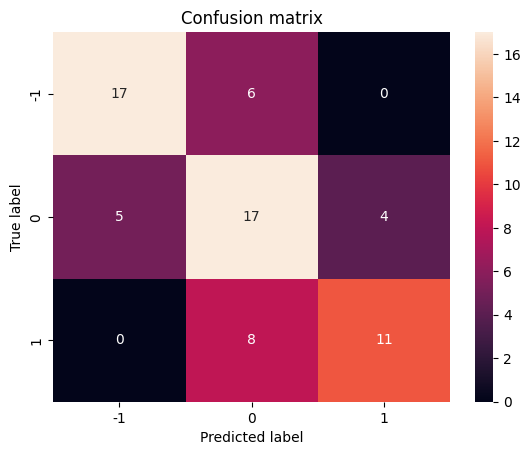

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178
bow elasticnet,0.676471,0.682804,0.696465,0.674852,0.837479,0.840521
bow release title,0.661765,0.666369,0.684816,0.657308,0.834681,0.837807


In [13]:
metric, _ = calc_metrics(
    bow_title_release, y, 
    LogisticRegression, 
    name='bow release title', 
    **best_model.get_params()
)
metrics = pd.concat([metrics, metric])
metrics

Добавление мешка слов по названию не улучшило нашу модель, а только усложнило ее. Попробуем к мешку слов по текстам релизов, с самыми важными словами добавим количественные признаки.

In [14]:
num_columns = ['inflation', 'rate', 'usd', 'usd_cur_change_relative']

scaler = StandardScaler()
scaler.fit(X[num_columns])
X[num_columns] = scaler.transform(X[num_columns])

In [15]:
all_data = np.concatenate((bow_title_release, X[num_columns].values), axis=1)

In [16]:
auc = Parallel(n_jobs=-1)(delayed(
    lambda c, l1_ratio: calc_metrics(
        all_data, y,
        LogisticRegression,
        name='bow all data', 
        plot=False, 
        solver='saga', 
        penalty='elasticnet', 
        C=c, 
        max_iter=10000, 
        l1_ratio=l1_ratio
    )
)(c, l1_ratio) for c in np.linspace(0.1, 30, 10) for l1_ratio in np.logspace(-3, 0, 6))

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=16.711111111111112, l1_ratio=0.001, max_iter=10000,
                   penalty='elasticnet', solver='saga')
ROC-AUC = 0.8373232412134014


              precision    recall  f1-score   support

        -1.0       0.75      0.78      0.77        23
         0.0       0.57      0.62      0.59        26
         1.0       0.75      0.63      0.69        19

    accuracy                           0.68        68
   macro avg       0.69      0.68      0.68        68
weighted avg       0.68      0.68      0.68        68



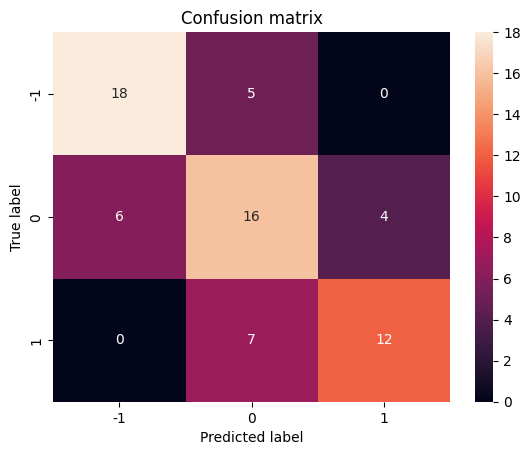

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178
bow elasticnet,0.676471,0.682804,0.696465,0.674852,0.837479,0.840521
bow release title,0.661765,0.666369,0.684816,0.657308,0.834681,0.837807
bow release all num,0.676471,0.681421,0.690476,0.676524,0.833032,0.836091


In [17]:
metric, _ = calc_metrics(
    all_data, y, 
    LogisticRegression, 
    name='bow release all num', 
    **best_model.get_params()
    )

metrics = pd.concat([metrics, metric])
metrics

Добавление количественных переменных только ухудшило нашу модель. Попробуем на мешке слов обученный на релизах обучить SVC.

In [18]:
auc = Parallel(n_jobs=-1)(delayed(
    lambda c, kernel: calc_metrics(
        bow, y,
        SVC,
        name='bow svc only release', 
        kernel=kernel,
        C=c,
        plot=False, 
        probability=True,
    )
)(c, kernel) for c in [0.01, 0.05, 0.1, 0.5, 1, 3, 5, 7, 10] for kernel in ['linear', 'poly', 'rbf', 'sigmoid'])

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - SVC(C=10, kernel='linear', probability=True)
ROC-AUC = 0.7976001877603709


              precision    recall  f1-score   support

        -1.0       0.71      0.65      0.68        23
         0.0       0.57      0.62      0.59        26
         1.0       0.63      0.63      0.63        19

    accuracy                           0.63        68
   macro avg       0.64      0.63      0.64        68
weighted avg       0.64      0.63      0.63        68



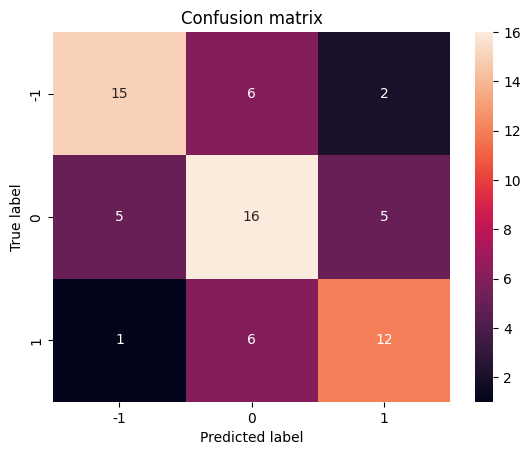

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178
bow elasticnet,0.676471,0.682804,0.696465,0.674852,0.837479,0.840521
bow release title,0.661765,0.666369,0.684816,0.657308,0.834681,0.837807
bow release all num,0.676471,0.681421,0.690476,0.676524,0.833032,0.836091
bow svc only release,0.632353,0.635330,0.639098,0.633046,0.773909,0.777299


In [19]:
metric, _ = calc_metrics(
    bow, y, 
    SVC, 
    name='bow svc only release', 
    **best_model.get_params()
    )

metrics = pd.concat([metrics, metric])
metrics

Метод опорных векторов показал качество хуже, чем логистическая регрессия. Сохраним результаты экспериментов.

In [20]:
metrics.to_csv('metrics.csv')